# Tutorial: Access to ThorVision Video Data

This notebook demonstrates how to read ThorVision video metadata from XDAQ (.bin), and extract its corresponding frame.

## Step 1: Load Demo Data

In [4]:
import urllib.request
import zipfile
from pathlib import Path
import os

# Define URL and filenames
DATA_URL = "https://xvc001.sgp1.digitaloceanspaces.com/xdaq_demo_data.zip"
DATA_FILENAME = "xdaq_demo_data.zip"
zip_path = Path(DATA_FILENAME)

# Download the data if it doesn't exist locally
if not zip_path.exists():
    print(f"Downloading {DATA_URL}...")
    urllib.request.urlretrieve(DATA_URL, zip_path)
    print("Download complete.")
else:
    print(f"'{DATA_FILENAME}' already exists, skipping download.")

# Unzip the data
if not Path("data/video_data").exists() or not Path("data/test.rhd").exists():
    print(f"Extracting {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Extraction complete.")
else:
    print("Data already extracted, skipping extraction.")

# Define paths for the rest of the notebook
video_folder = "data/video_data"
rhd_file = "data/test.rhd"

print(f"Data is ready.")
print(f"Video folder: {os.path.abspath(video_folder)}")
print(f"RHD file: {os.path.abspath(rhd_file)}")

'xdaq_demo_data.zip' already exists, skipping download.
Extracting xdaq_demo_data.zip...
Extraction complete.
Data is ready.
Video folder: C:\Users\kontex\Desktop\project\ThorVisionTutorial\data\video_data
RHD file: C:\Users\kontex\Desktop\project\ThorVisionTutorial\data\test.rhd


## Step 2: Read XDAQ Metadata

Now that we have the data, we'll read the video metadata from a `.bin` file. We need to find the `.bin` file in our `video_folder`.

In [5]:
import os
import numpy as np

# Define a structured dtype for the metadata
metadata_dtype = np.dtype([
    ('fpga_timestamp', np.uint64),
    ('rhythm_timestamp', np.uint32),
    ('ttl_in', np.uint32),
    ('ttl_out', np.uint32),
    ('spi_perf_counter', np.uint32),
    ('reserved', np.uint64)
])

# Create the full dtype with a nested metadata field.
record_dtype = np.dtype([
    ('video_timestamp', np.uint64),
    ('metadata', metadata_dtype)
])

def read_XDAQFrameData(filename: str) -> np.ndarray:
    with open(filename, 'rb') as f:
        data = f.read()
        
    # Convert binary blob directly into an array using the structured dtype.
    return np.frombuffer(data, dtype=record_dtype)

# Find the first .bin file in the video folder
metadata_file = None
for f in os.listdir(video_folder):
    if f.endswith('.bin'):
        metadata_file = os.path.join(video_folder, f)
        break

if metadata_file:
    xdaq_data = read_XDAQFrameData(metadata_file)
    print(f"Successfully loaded XDAQ metadata from {metadata_file}")
    print(f"Number of frames: {len(xdaq_data)}")
    print("--- First metadata record ---")
    print('video_timestamp:', xdaq_data[0]['video_timestamp'])
    print('fpga_timestamp:', xdaq_data[0]['metadata']['fpga_timestamp'])
    print('rhythm_timestamp:', xdaq_data[0]['metadata']['rhythm_timestamp'])
    print('ttl_in:', xdaq_data[0]['metadata']['ttl_in'])
    print('ttl_out:', xdaq_data[0]['metadata']['ttl_out'])
    print('spi_perf_counter:', xdaq_data[0]['metadata']['spi_perf_counter'])
    print('reserved:', xdaq_data[0]['metadata']['reserved'])
else:
    print("No .bin metadata file found in the video folder.")
    

Successfully loaded XDAQ metadata from data/video_data\AVerMedia PW513-2-2025-02-20_15-58-26.bin
Number of frames: 1995
--- First metadata record ---
video_timestamp: 26213000000
fpga_timestamp: 78118894449
rhythm_timestamp: 0
ttl_in: 0
ttl_out: 0
spi_perf_counter: 809483121
reserved: 0


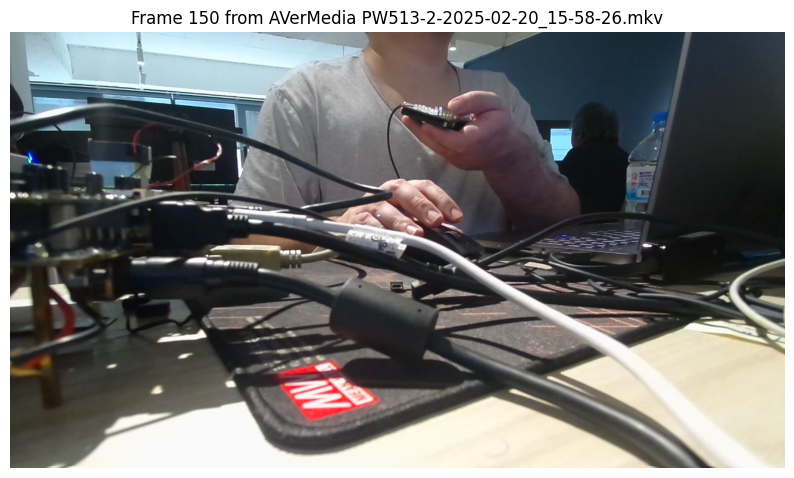

--- Metadata for Frame 150 ---
video_timestamp: 28715000000
fpga_timestamp: 78119144582
rhythm_timestamp: 0
ttl_in: 0
ttl_out: 0
spi_perf_counter: 809733254
reserved: 0


In [6]:
import cv2
import matplotlib.pyplot as plt

# Construct the video file path from the metadata file path
video_file, _ = os.path.splitext(metadata_file)
video_file += '.mkv'

if not os.path.exists(video_file):
    print(f"Video file not found at: {video_file}")
else:
    # Select a frame to display
    frame_to_show = 150

    cap = cv2.VideoCapture(video_file)
    if not cap.isOpened():
        print("Error: Could not open video file.")
    else:
        # Set the video capture to the desired frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_to_show)
        ret, frame = cap.read()

        if ret:
            # OpenCV loads images in BGR format, so we convert to RGB for display
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Display the frame
            plt.figure(figsize=(10, 8))
            plt.imshow(frame_rgb)
            plt.title(f'Frame {frame_to_show} from {os.path.basename(video_file)}')
            plt.axis('off')
            plt.show()
            
            # Print corresponding metadata
            print(f"--- Metadata for Frame {frame_to_show} ---")
            metadata_record = xdaq_data[frame_to_show]
            print(f'video_timestamp: {metadata_record["video_timestamp"]}')
            for field in metadata_record['metadata'].dtype.names:
                print(f'{field}: {metadata_record["metadata"][field]}')

        else:
            print(f"Error: Could not read frame {frame_to_show}.")
            
        cap.release()